In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
ee.Initialize()

In [3]:
"""Composite an image collection and clip it to a boundary from a fusion table.
See also: Filtered Seasonal Composite, which filters the
collection by bounds instead.
"""

# Clip to the output image to the California state boundary.
area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8')
      .filter(ee.Filter().eq('Name', 'California')))

area = (ee.FeatureCollection('ft:1QPasan0i6O9uUlcYkjqj91D7mbnhTZCmzS4t7t_g').filter(ee.Filter().eq('id', '107')))

# import the RS products

modis = ee.ImageCollection('MCD43A4_NDVI') #

years = [x for x in range(2000, 2016)]

In [6]:
# Functions

def filter_date_modis(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,1,1)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select("NDVI")
    return prod

def aggregate(product,year):

    # Filter
    filtered = filter_date_modis(product, year)
    
    # bbox 
    bounds = area.geometry().bounds()

    # calculate the monthly mean
    def calcMean(imageCollection,year):
        mylist = ee.List([])
        months = range(2,9)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).mean();
                clipped = w.clip(area)
                mask = clipped.mask()
                masked = ee.Image(0).where(mask, clipped)
                fin = masked.clip(bounds)
                mylist = mylist.add(fin.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    seasonal = ee.ImageCollection(calcMean(filtered, year))
    
    # select the region of interest, 500 is the cellsize in meters
    seasonal = seasonal.getRegion(bounds,500,"epsg:4326").getInfo()

    return seasonal 

def make_df_from_imcol(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df.constant)
    
    return lons, lats, data

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable):
    df = df[df.id == "6"] # TODO : average on 0-6
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

In [7]:
finals_modis = []
for year in years:
    finals_modis.append(aggregate(modis,year))

In [8]:
fin_modis_dfs = []
for i in finals_modis:
    fin_modis_dfs.append(df_from_ee_object(i))

In [9]:
arrs = []
for i in fin_modis_dfs:
    arrs.append(array_from_df(i,"constant"))

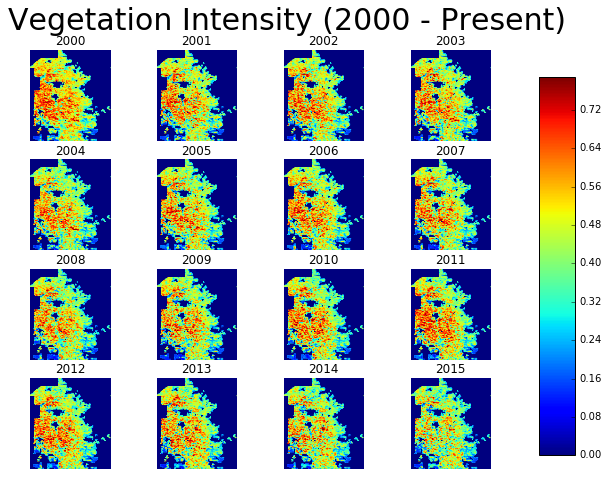

In [10]:
#del(fig,axs)

fig, axs = plt.subplots(4,4, figsize=(10,7.5))
axs = axs.ravel()

plt.suptitle('Vegetation Intensity (2000 - Present)', size = 30)

for i in range(len(arrs)):
    
    a = axs[i].imshow(arrs[i])#(fin_modis_dfs[i]['longitude'],fin_modis_dfs[i]['latitude'],marker = "s",c = fin_modis_dfs[i]['constant'],s= 20, lw = 0)
    axs[i].set_title(2000+i)
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(a, cax=cbar_ax)
plt.show()

In [13]:
# Grab the training data 
cwd = os.getcwd()
y_dir = [os.path.join(cwd,x) for x in os.listdir(os.getcwd()) if "yields" in x][1]
fn = [os.path.join(y_dir,x) for x in os.listdir(y_dir) if "107" in x][0]

d = json.load(open(fn))
yrs = [str(x) for x in years]
training_dict = { year: d[year] for year in yrs }
training = training_dict.values()

In [14]:
labels = training_dict.copy()
training = dict(zip(yrs,arrs))

In [15]:
def stack_arrays(x_train,x_test,y_train,y_test):
    X_train = np.stack(x_train[:-1])
    y_train = np.stack(training[:-1])
    X_test = np.stack(arrs[-1:])
    y_test = np.stack(training[-1:])
    X_train.shape, X_test.shape, y_train.shape, y_test.shape
    return x_train, x_test, y_train, y_test

In [16]:
for yr in yrs[:1]:
    x_train = [v for v in training.keys() if v!=yr]
    x_train = {key:training[key] for key in x_train}
    x_train = x_train.values()
    x_test = training[yr]
    y_train = [v for v in labels.keys() if v!=yr]
    y_train = {key:labels[key] for key in y_train}
    y_train = y_train.values()
    y_test = labels[yr]
    y_test = [y_test]
    y_test = np.array(y_test)
    
    #print(type(x_train), type(x_test), type(y_train), type(y_test))
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    
    # Stack
    x_train = np.stack(x_train)
    x_test = np.stack(x_test)
    y_train = np.stack(y_train)
    y_test = np.stack(y_test)
    
    print(type(x_train), type(x_test), type(y_train), type(y_test))
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    
    # tile
    x_train = np.tile(x_train,(10,1,1))
    y_train = np.tile(y_train,(10))
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    
    # reshape
    X_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]).astype('float32')
    X_test = x_test.reshape(1, 1, x_test.shape[0], x_test.shape[1]).astype('float32')
    
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    print(type(x_train), type(x_test), type(y_train), type(y_test))

(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>, <type 'numpy.ndarray'>, <type 'numpy.ndarray'>)
((15, 195, 170), (195, 170), (15,), (1,))
((150, 195, 170), (195, 170), (150,), (1,))
((150, 1, 195, 170), (1, 1, 195, 170), (150,), (1,))
(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>, <type 'numpy.ndarray'>, <type 'numpy.ndarray'>)


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [18]:
X_train = np.stack(arrs[:-1])
y_train = np.stack(training[:-1])
X_test = np.stack(arrs[-1:])
y_test = np.stack(training[-1:])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

TypeError: unhashable type

In [ ]:
X_train = np.tile(x_train,(10,1,1))
y_train = np.tile(y_train,(10))
X_train.shape,y_train.shape,

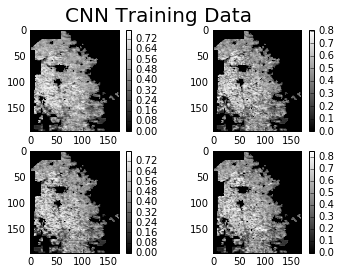

In [24]:
plt.suptitle("CNN Training Data", size = 20)
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.colorbar()
plt.show()

In [122]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]).astype('float32')

In [123]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((150, 1, 195, 170), (1, 1, 195, 170), (1,), (150,))

In [17]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 195, 170), activation='relu'))
    model.add(Conv2D(64, (20, 20), input_shape=(1, 195, 170), activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model
    

In [18]:
model = baseline_model()

In [155]:
year = "2015"
with open('{}_summary.txt'.format(year),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))


In [162]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 191, 166)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 172, 147)      819264    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 34, 29)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 34, 29)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 64, 34, 64)        1920      
_________________________________________________________________
flatten_1 (Flatten)          (None, 139264)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 139264)            0         
__________

In [20]:
# build the model

# Fit the model
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=15, verbose=2)
# Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
error=100*np.abs((model.predict(X_test)-y_test)/y_test)

print("CNN Error: %.2f%%" % error[0])

Train on 135 samples, validate on 15 samples
Epoch 1/10
 - 446s - loss: 15821155161429.3340 - acc: 0.0000e+00 - val_loss: 15807334580224.0000 - val_acc: 0.0000e+00
Epoch 2/10
 - 437s - loss: 15743056405390.2227 - acc: 0.0000e+00 - val_loss: 15598117453824.0000 - val_acc: 0.0000e+00
Epoch 3/10
 - 433s - loss: 15214733601450.6660 - acc: 0.0000e+00 - val_loss: 14488957878272.0000 - val_acc: 0.0000e+00
Epoch 4/10
 - 428s - loss: 13088703352376.8887 - acc: 0.0000e+00 - val_loss: 10728173993984.0000 - val_acc: 0.0000e+00
Epoch 5/10
 - 551s - loss: 7445766908586.6670 - acc: 0.0000e+00 - val_loss: 3066488160256.0000 - val_acc: 0.0000e+00
Epoch 6/10
 - 656s - loss: 998841068202.6666 - acc: 0.0000e+00 - val_loss: 1140260864000.0000 - val_acc: 0.0000e+00
Epoch 7/10
 - 431s - loss: 1007000352995.5557 - acc: 0.0000e+00 - val_loss: 184427184128.0000 - val_acc: 0.0000e+00
Epoch 8/10
 - 435s - loss: 213430251975.1111 - acc: 0.0000e+00 - val_loss: 381869260800.0000 - val_acc: 0.0000e+00
Epoch 9/10
 - 4

In [21]:
error

array([[ 11.81544958]])

In [157]:
model.predict(X_test)[0][0]

4265464.0

In [24]:
y_test

array([ 4141459.])

In [160]:
result = {}
result['year'] = year
result['predicted'] = model.predict(X_test)[0][0]
result['actual'] = y_test[0]
result['error'] = error[0][0]

In [161]:
result

{'actual': 4677648.0,
 'error': 11.815449579483946,
 'predicted': 4265464.0,
 'year': '2015'}